<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**Título:** Modelo para la detección de Noticias Falsas en tweets con formato de texto en el contexto político colombiano para las elecciones del año 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [ ]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install scikit-plot
!pip install bayesian-optimization
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install stop-words

# paquetes necesarios para trabajar con BERT
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 235 kB 5.5 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=6d80eafbc5c9a85539a2aed49e25d1446653d912015ac2cd5768bfe7e7556aa1
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 12.0 MB 5.5 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019121 sha256=947225def8f86db2ee95dc6d2717d300a34c966d55874ad53f562792f34eb564
  Stored in directory: /root/.cache/pip/wheels/64/69/41/6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
  Created wheel for stop-words: filename=stop_words-2018.7.23-p

#**Librerias**

In [ ]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import (
    drive,
    files
)
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from stop_words import get_stop_words
import pickle
import xgboost as xgb
from sklearn.linear_model import PassiveAggressiveClassifier
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#### 
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

## libreria para descargar un .zip desde una url de descarga
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [ ]:
# al llamar la función y pasarle una URL, descarga el arhcivo que debe estar en formato .zip y lo descomprime en la ruta content de colab
def download_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

In [ ]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [ ]:
#Funcion para obtener los tweets de un usuario especifio de twitter - Se quitan los RT
def get_tweets(api,username,items,rts):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended',include_rts=rts).items(items)):
      tweets[tweet.id]= {
          'full_text': tweet.full_text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [ ]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [ ]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    text=text.replace("   ", "")
    return text    

In [ ]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [ ]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))

In [ ]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [ ]:
stoplist = list(get_stop_words('spanish'))  # 308 words
nltk_words = list(stopwords.words('spanish')) #
stoplist.extend(nltk_words)
def remove_stopwords(text):
    # Remover stop words
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [ ]:
nlp = spacy.load('en_core_web_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [ ]:
def remove_links(text): 
    # Remover urls 
    text=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r'opr-littps://S+','',text)
    return text

In [ ]:
def remove_numbers(text):
    # Remover numeros
    formatted_text=''.join((x for x in text if not x.isdigit()))
    formatted_text= re.sub(r"NUMBER", ' ', formatted_text)
    formatted_text= re.sub(r"number", ' ', formatted_text)
    return formatted_text

In [ ]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):     

    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text) 
   
    if links == True: #remove links
        data = remove_links(data)
        
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
    
    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)
    
    if characters_specials == True: # Remover signos de puntuación
        data = remove_special_characters(data)

    if numbers_remove == True: # Remover números
        data = remove_numbers(data)

    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data) 

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data) 

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)    
       
    return data

In [ ]:
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real' or campo=='0':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

In [ ]:
def create_model_production(name_model,model):
  with open(name_model+'.pkl','wb') as model_pkl:
    pickle.dump(model, model_pkl, protocol=2)

In [ ]:
def randomsearchmodels(model,hyperparameters_tuning,features_train_f,labels_train_f,features_test_f,labels_test_f):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=100,scoring='accuracy',cv=5,verbose=1,random_state=8)
  gridsearch.fit(features_train_f,labels_train_f)
  predictions = gridsearch.predict(features_test_f)
  accuracy_model=accuracy_score(predictions, labels_test_f)
  return gridsearch,predictions,accuracy_model

In [ ]:
def tifdf_features (X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features):
  tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
  features_train = tfidf.fit_transform(X_train)
  features_test = tfidf.transform(X_test)
  labels_train = y_train
  labels_test = y_test
  return features_train,features_test,labels_train,labels_test,tfidf

In [ ]:
def removeFinalSpace(x):
    if type(x)==str:
        return x.lstrip()
    else:
        return x

In [ ]:
# removerlos al final  
def removeInitSpace(x):
    if type(x)==str:
        return x.rstrip()
    else:
        return x

In [ ]:
#@title Seleccione el modelo de BERT para el fine-tune
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'distilbert_multi_cased_L-6_H-768_A-12':
      'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


#**Twitter**

Credenciales Consumo API

In [ ]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [ ]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

In [ ]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"petrogustavo",10,False)

In [ ]:
df_tweets.full_text.iloc[1]

#**Cargar Corpus**

In [ ]:
url_archivos='https://docs.google.com/uc?export=download&id=1l6T0xw_WIwHEtCgMwGJNjP7mqDnoRN3o'
download_unzip(url_archivos)

In [ ]:
# opcionalmente se pueden cargar los archivos de trabajo desde el area de trabajo local. Estos se deben cargar previamente 
df=pd.read_excel("files/Corpus_Noticias_Falsas.xlsx")
df2=pd.read_excel("files/train.xlsx")
df3=pd.read_csv("files/fakes2000.csv", skipinitialspace=True, skip_blank_lines=True, encoding='utf-8')
df_stopwords=pd.read_csv("files/spanish.txt")

In [ ]:
df=df[['Categoria','Texto']] # Corpus creado por Eduardo Flores y Juan Montano
df

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
492,Noticia Real,Los pasacalles de la campaña de Comunes en Pue...
493,Noticia Real,En medio de uno de los momentos más difíciles ...
494,Noticia Real,Entre el sábado 29 de enero y el viernes 11 de...
495,Noticia Real,El presidente Iván Duque respondió a la decisi...


In [ ]:
#stoplist.clear() : funcion para borra el contenido de la lista
stoplist.extend(df_stopwords['stopwords'].tolist())
len(stoplist)

1229

In [ ]:
# eliminar las tildes de los stopword para la limpieza.
list_stop_words = []
for n in stoplist:
  list_stop_words.append(unidecode.unidecode(n))
stoplist=list_stop_words

In [ ]:
df.value_counts(df['Categoria'])

Categoria
Noticia Real     260
Noticia Falsa    237
dtype: int64

In [ ]:
## seleccionar las dos columans de trabajo
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

,Category,Text
0,Fake,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR..."
1,Fake,"La palabra ""haiga"", aceptada por la RAE La Rea..."
2,Fake,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3,True,UNAM capacitará a maestros para aprobar prueba...
4,Fake,Alerta: pretenden aprobar libros escolares con...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [ ]:
# se renombran las columas para realizar la union de los dos corpus
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [ ]:
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [ ]:
## corpus de 2000 noticias (Fake2000), se nombra como df3 ya que tenemos 3 corpus por unir
df3

,class,Text
0,True,Algunas de las voces extremistas más conocida...
1,True,Después de casi dos años y medio de luchas po...
2,True,Dos periodistas birmanos de la agencia Reuters...
3,True,El Cuerpo Nacional de Policía ha detenido a cu...
4,True,El desfile de la firma en Roma se convierte en...
...,...,...
1995,True,El Consejo de Gobierno ha dado su visto bueno...
1996,True,Investigadores valencianos han desarrollado u...
1997,True,Los arrestados actuaban en coches y en establ...
1998,True,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# visualizar la tabla de frecuencias de las categorias. Las etiquetas se encuentran balanceadas.
df3['class'].value_counts()

True     1000
False    1000
Name: class, dtype: int64

In [ ]:
# renombramos las columnas para que queden todas con igual nombre, de esta manera se realiza correctamente la concatenación.
df3=df3.rename(columns={'class':'Categoria', 'Text':'Texto'})

In [ ]:
#Dataframe con 500 noticias
df_base_cp=df

In [ ]:
#Union de los dos tres corpus
df_base=pd.concat([df,df2,df3], axis=0, ignore_index=False)

In [ ]:
# visualización de como queda el corpus de 3173 noticias.
df_base

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
1995,True,El Consejo de Gobierno ha dado su visto bueno...
1996,True,Investigadores valencianos han desarrollado u...
1997,True,Los arrestados actuaban en coches y en establ...
1998,True,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# se observa que las clases True estan siendo leidas de forma diferente(problema por resolver)
df_base.Categoria.value_counts()

True             1000
False            1000
Fake              338
True              338
Noticia Real      260
Noticia Falsa     237
Name: Categoria, dtype: int64

In [ ]:
# para mitigar temporalmente el error, se exporta el archivo .csv (de esta manera se formatean los datos).
df_base.to_csv('salida.csv')

In [ ]:
# nuevamente se realiza la lectura del corpus (solución temporal)
df_base=pd.read_csv('salida.csv')

In [ ]:
# Se observa como la categoria True ya fue leida como una sola. Pso siguiente Unificar las categorias.
df_base.Categoria.value_counts()

True             1338
False            1000
Fake              338
Noticia Real      260
Noticia Falsa     237
Name: Categoria, dtype: int64

In [ ]:
# cambiar el nombre de la categoria para dejar el corpus uniforme: Fake=Noticia Falsa, True=Noticia Real
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

,Unnamed: 0,Categoria,Texto
0,0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...,...
3168,1995,Noticia Real,El Consejo de Gobierno ha dado su visto bueno...
3169,1996,Noticia Real,Investigadores valencianos han desarrollado u...
3170,1997,Noticia Real,Los arrestados actuaban en coches y en establ...
3171,1998,Noticia Real,El Rey ha encargado este miércoles a Pedro Sá...


In [ ]:
# Conteo del numero de noticias falsas y verdaderas. Se observa que ahora si quedaron balanceadas.
df_base.Categoria.value_counts()

Noticia Real     1598
Noticia Falsa    1575
Name: Categoria, dtype: int64

In [ ]:
#Dataframe con 1000 noticias - Union Corpus JM y Posadas-Duran
df_merge=df_base

#**Preprocesamiento**

Tareas de pre-procesamiento a realizar:
* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

### **Preprocesamiento Corpus del proyecto**

In [ ]:
#Preprocesamiento Corpus 500 noticias
List_News = df_base_cp['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_base_cp['Processed_Text'] = Complete_Content

### **Preprocesamiento Corpus Unido**

In [ ]:
#Preprocesamiento Corpus 1000 noticias
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

In [ ]:
df_merge.Texto.iloc[1093]

In [ ]:
a="Carlos Trejo producirá, dirigirá y protagonizará la versión mexicana de Los Cazafantasmas México.- El investigador de fenómenos paranormales, Carlos Trejo, anunció que en mayo iniciará el rodaje de la versión mexicana de la película \"Los Cazafantasmas\", cinta que él producirá, dirigirá y protagonizará junto con otros reconocidos actores nacionales.\nTrejo mencionó que –a diferencia del film original- su película tratará el tema de los fantasmas de manera seria y respetuosa, y no con las \"payasadas\" de la versión americana:\n\"Como ya todos saben yo estuve a punto de morir por culpa de un espectro del más allá que atormentó a mi familia cuando vivíamos en Cañitas. Las situaciones paranormales son un tema serio y delicado, me parece una grosería que Hollywood saque una película bufándose de esta terrible situación, eso demuestra que no les importa hacer cine de calidad, prefieren producir películas tontas y huecas con tal de llenarse los bolsillos de dinero en vez de realizar cine de calidad\", señaló.\nCarlos mencionó que no es uh novato en el cine ya que su libro \"Cañitas\" fue adaptado a la pantalla grande en el *NUMBER*:\n\"Siempre tuve la espinita de producir películas de calidad para engrandecer a nuestro nacional. Ahora que Hollywood va a estrenar la versión femenina de los Cazafantasmas quise producir la versión mexicana para demostrarles que nuestro cine tiene muchísima mejor calidad y es más profundo. Quiero hacer de esta película toda una obra de arte\", señaló.\nTrejo mencionó que su película será un drama y no comedia, además de que los cazafantasmas de su film intentarán atrapar espectros reales que él ha conocido:\n\"Los fantasmas que verán en mi cinta serán fantasmas reales con los que he convivido a través de los años. Mi película será una especie de documental que le mostrará al mundo que no estamos solos y que estos espectros son peligrosos, pero que afortunadamente hay personas como yo que estamos dispuesto a dar la vida con tal de controlarlos para que no dañen al mundo\", señaló.\nPor último, Trejo confirmó que el grupo de cazafantamas mexicanos estará integrado (además de él) por los actores Adrián Uribe, Omar Chaparro, Martha Higareda (la única mujer en el grupo) y el investigador en fenómenos extraterrestres Jaime Maussan, con quien recientemente hizo las pases."
b=unidecode.unidecode(a,'utf-8')
c=remove_special_characters(b)
d=remove_stopwords(c)
d


In [ ]:
df_base_cp.Processed_Text.iloc[400]

In [ ]:
df_merge.Processed_Text.iloc[200]

In [ ]:
df_merge.Processed_Text.iloc[1000]

In [ ]:
df_merge.Processed_Text.iloc[1093]

###**División del Corpus - Noticias Falsas y Verdaderas**

In [ ]:
#División Dataframe Corpus de referencia
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']

In [ ]:
#División Dataframe Corpus creado
real_news_cp=df_base_cp[df_base_cp['Categoria'] == 'Noticia Real']
fake_news_cp = df_base_cp[df_base_cp['Categoria'] == 'Noticia Falsa']

# **Analitica Descriptiva**

## **Analitica Corpus Propio**

###**Histograma de categorias**

In [ ]:
# Distribución de noticias falsas y verdaderas Corpus 500 noticias
ax = sns.countplot(x="Categoria", data=df_base_cp)

### Word Cloud Real News Corpus Propio

In [ ]:
#Wordcloud 500 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Fake News Corpus Propio

In [ ]:
#Wordcloud 500 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Analitica Corpus Unido**

###**Histograma de categorias**

In [ ]:
# Distribución de noticias falsas y verdaderas Corpus 1000 noticias
ax = sns.countplot(x="Categoria", data=df_merge)

### Word Cloud Fake News Corpus Unido

In [ ]:
#Wordcloud 1000 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Real News Corpus Unido

In [ ]:
#Wordcloud 1000 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Codificación de etiquetas

In [ ]:
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [ ]:
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

In [ ]:
df_base_cp['Codigo'] = df_base_cp['Categoria']
df_base_cp = df_base_cp.replace({'Codigo':category_codes})

## División de datos

Se realiza el particionamiento de los datos en prueba y validación.

In [ ]:
#Division de datos - Corpus propio
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(df_base_cp['Processed_Text'], 
                                                    df_base_cp['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

In [ ]:
#Division de datos - Corpus de referencia + Corpus creado = 1000 noticias
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## **Representación del texto**

La representación del texto se realiza con sklearn mediante la técnica Tfidf parametrizado con unigramas y bigramas del texto

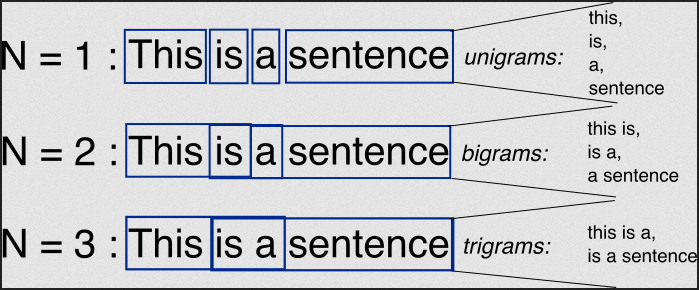

**ngram_range ** tuple (min_n, max_n) default=(1,1): Representa el limite inferior y superior para los n-grams en la extracción del texto ngram_range=(1,2) representa unigrams y bigrams a aplicarse

**max_df** parametros para ignorar terminos demasiado frecuentes que superan el umbral. ejm: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".

**min_df** parametros para ignorar terminos no frecuentes y que superen un umbral. ejm: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

**max_features:** crea un vocabulario que solo tenga el top max_features ordenadas por frecuencia de términos en todo el corpus.

fuente: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [ ]:
# Eleccion de parametros
ngram_range = (1,3) # unigrams, bigrams, trigrams
min_df = 0.001 # se eliminan los terminos poco frecuentes que aparezcan como minimo en el 0.1% de los documentos
max_df = 0.8 # se eliminan los terminos demaciado frecuentes que aparezcan en almenos el 80% de los documentos (similar a stopwords).
max_features = 300 # 

In [ ]:
# Corpus Propio
features_train_cp,features_test_cp,labels_train_cp,labels_test_cp,tfidf_cp=tifdf_features(X_train_cp, X_test_cp, y_train_cp, y_test_cp,ngram_range,max_df,min_df,max_features)

In [ ]:
# Corpus Unido
features_train,features_test,labels_train,labels_test,tfidf=tifdf_features(X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features)

In [ ]:
print(features_train_cp.shape)
print(features_train.shape)

In [ ]:
count_values = features_train.toarray().sum(axis=0)
# list of ngrams
vocab = tfidf.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram

## Modelos de clasificación

Metricas de evaluación

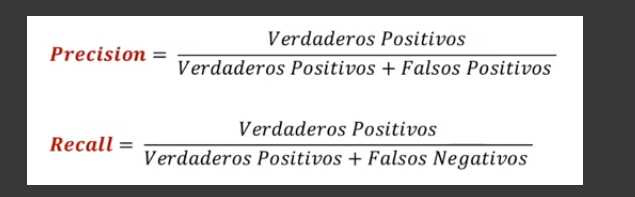

### **RandomForestClassifier**


In [ ]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(hyperparameters_tuning)

#### **RandomForest Classifier - Corpus del proyecto**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search_cp = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search_cp.fit(features_train_cp, labels_train_cp)
print("The best hyperparameters from Random Search are:")
print(random_search_cp.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_cp.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf_cp = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=2, max_features='auto', max_depth=None, bootstrap=True)
clf_cp.fit(features_train_cp, labels_train_cp)
clf_predict_cp = clf_cp.predict(features_test_cp)

In [ ]:
# Matrix de confunsión 500 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, clf_predict_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
accuracy_randomforest_cp=accuracy_score(labels_test_cp, clf_predict_cp)
print("Accuracy Corpus propio",accuracy_randomforest_cp)

In [ ]:
clf_predict_proba_cp = clf_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, clf_predict_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,clf_predict_proba_cp)

#### **RandomForest Classifier - Corpus Unido**

In [ ]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

In [ ]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=80, bootstrap=True)
clf.fit(features_train, labels_train)
clf_predict = clf.predict(features_test)

In [ ]:
# Matrix de confunsión 1000 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
accuracy_randomforest=accuracy_score(labels_test, clf_predict)
print(accuracy_randomforest)

In [ ]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

## **Naive Bayes**

### **Naive Bayes Corpus del proyecto**

In [ ]:
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb_cp,predictions_nb_cp,accuracy_nb_cp=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
MultinomialNB().get_params().keys()

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb_cp)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_nb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_nb_cp=best_model_nb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_nb_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_nb_cp)

### **Naive Bayes Corpus Unido**

In [ ]:
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb,predictions_nb,accuracy_nb=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_nb=best_model_nb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_nb)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_nb)

## **SVC**

### **SVC Corpus del proyecto**

In [ ]:
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc_cp,predictions_svc_cp,accuracy_svc_cp=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc_cp)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_svc_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_svc_cp=best_model_svc_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_svc_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_svc_cp)

### **SVC Corpus Unido**

In [ ]:
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc,predictions_svc,accuracy_svc=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)                                       

In [ ]:
print("SVM Accuracy Score -> ",accuracy_svc)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_svc)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
predict_svc=best_model_svc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_svc)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,predict_svc)

## **Logistic Regression**

### **Logistic Regression Corpus del proyecto**

In [ ]:
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_logistic_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_logistic_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **Logistic Regression Corpus Unido**

In [ ]:
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic,predictions_logistic,accuracy_logistic=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_logistic)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_logistic.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **XGBoost**

### **XGBoost Corpus del proyecto**

In [ ]:
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb_cp,predictions_xgb_cp,accuracy_xgb_cp=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb_cp)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_xgb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
y_pred_proba_cp= best_model_xgb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **XGBoost Corpus Unido**

In [ ]:
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb,predictions_xgb,accuracy_xgb=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

In [ ]:
print("XGBoost Accuracy Score: ",accuracy_xgb)

In [ ]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_xgb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [ ]:
dataframe_graf

In [ ]:
y_pred_proba= best_model_xgb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **Redes Neuronales**

### **Red Neuronal Corpus del proyecto**

In [ ]:
# create model
#features_train_cp.shape[1] representa el numero de columnas de los datos de entrenamiento.
tf.keras.backend.clear_session()
model = Sequential()
model.add(Dense(12, input_dim=features_train_cp.shape[1], activation='relu'))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
print(features_train_cp.shape)
print(features_test_cp.shape)
print(type(features_train_cp))
print(type(labels_test_cp))

print((features_train_cp.shape[1]))

In [ ]:
X_train_nn_cp=features_train_cp.toarray()
y_train_nn_cp=labels_train_cp.to_numpy()
X_test_nn_cp=features_test_cp.toarray()
y_test_nn_cp=labels_test_cp.to_numpy()

In [ ]:
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
entrenamiento=model.fit(x= X_train_nn_cp, 
                        y=y_train_nn_cp,
                        validation_data=(X_test_nn_cp,
                                         y_test_nn_cp),
                        batch_size=256,
                        callbacks=[callback],
                        epochs=500,
                        verbose=1)

In [ ]:
accuracy_nn_cp=max(entrenamiento.history['val_accuracy'])

In [ ]:
## grafica de la evolución de la funcion de perdida

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

### **Red Neuronal Corpus Unido**

In [ ]:
tf.keras.backend.clear_session()
# create model
#features_train.shape[1] representa el numero de columnas de los datos de entrenamiento.

model = Sequential()
model.add(Dense(128, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(64 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(32 , activation='relu' ))
model.add(Dense(8 , activation='relu' ))
model.add(Dense(1 , activation='sigmoid' ))

In [ ]:
# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(type(features_train))
print(type(labels_test))

In [ ]:
X_train_nn=features_train.toarray()
y_train_nn=labels_train.to_numpy()
X_test_nn=features_test.toarray()
y_test_nn=labels_test.to_numpy()

In [ ]:
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
entrenamiento=model.fit(x= X_train_nn, 
                        y=y_train_nn,
                        validation_data=(X_test_nn,
                                         y_test_nn),
                        batch_size=256 ,
                        epochs=500,
                        callbacks=[callback], 
                        verbose=1)

In [ ]:
accuracy_nn=max(entrenamiento.history['val_accuracy'])
print(accuracy_nn)

In [ ]:
## grafica de la evolución de la funcion de perdida

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch
  plt.figure(figsize=(10,5))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'], label="Val Error")
  #plt.plot(hist['epoch'], hist['mae'], label='MAE')
  #plt.plot(hist['epoch'], hist['val_mae'], label='val MAE')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(entrenamiento)

## **BERT**

### Entrenamiento de BERT Con corpus preprocesado



In [ ]:
# una vez realizado el preprocesamiento de todas la noticas  por fuera del entorno del notebbok, se cargan los datos disponible en la url:
url_bert='https://docs.google.com/uc?export=download&id=1Bxw4CFoAWUGQBw1rpIkqpnp5JyVFeULl'
download_unzip(url_bert)

In [ ]:
os.chdir('/content')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'news/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Entrenamiento de BERT con corpus sin procesar (Raw Text)


In [ ]:
# alistamiento de los datos para el entrenamiento con BERT
noticias_falsas=df_base[df_base['Categoria']=='Noticia Falsa']
noticias_verdaderas=df_base[df_base['Categoria']=='Noticia Real']

In [ ]:
# reset de los indices
noticias_falsas=noticias_falsas.reset_index(drop=True)
noticias_verdaderas=noticias_verdaderas.reset_index(drop=True)
len_noticias_falsas=len(noticias_falsas)
len_noticias_verdaderas=len(noticias_verdaderas)

In [ ]:
## ver el directorio actual de trabajo
import os
print(os.getcwd())
#os.chdir(os.getcwd())

/content


In [ ]:
# crear  los directorios y separar las noticias de manera individual
os.makedirs('Noticias')
os.chdir('Noticias')
os.makedirs('Noticias_falsas')
os.chdir('Noticias_falsas')
for n,i in zip(range(len_noticias_falsas), range(len_noticias_falsas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(noticias_falsas['Texto'][i])

In [ ]:
os.chdir('/content')
os.chdir('Noticias')
os.makedirs('Noticias_verdaderas')
os.chdir('Noticias_verdaderas')
for n,i in zip(range(len_noticias_verdaderas), range(len_noticias_verdaderas)):
    with open(f'{n}.txt', 'w') as n:
            n.write(noticias_verdaderas['Texto'][i])
os.chdir('/content')

In [ ]:
# para borra los directorios
#import shutil
#os.chdir('/content')
#shutil.rmtree('Noticias')

In [ ]:
## se leen las noticias utilizando las utilidades de keras
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'Noticias',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'Noticias',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3173 files belonging to 2 classes.
Using 2539 files for training.
Found 3173 files belonging to 2 classes.
Using 634 files for validation.


In [ ]:
# se define la arquitectura de la red neuronal utilizando a BERT para que haga parte del modelo (Fine Tunning)
tf.keras.backend.clear_session()
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

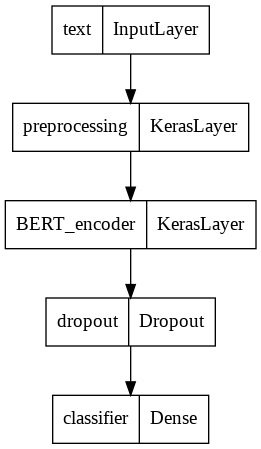

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
# definición de la funcion de perdida y la metrica a utilizar
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# parametrización
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compilación del modelo
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
## entrenamiento del modelo con todas la noticias.
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/10
80/80 [==============================] - 186s 2s/step - loss: 0.6003 - binary_accuracy: 0.6321 - val_loss: 0.5595 - val_binary_accuracy: 0.7366
Epoch 2/10
80/80 [==============================] - 154s 2s/step - loss: 0.3941 - binary_accuracy: 0.8070 - val_loss: 0.5087 - val_binary_accuracy: 0.8170
Epoch 3/10
80/80 [==============================] - 154s 2s/step - loss: 0.2714 - binary_accuracy: 0.8811 - val_loss: 0.6322 - val_binary_accuracy: 0.7997
Epoch 4/10
80/80 [==============================] - 154s 2s/step - loss: 0.1770 - binary_accuracy: 0.9299 - val_loss: 0.6968 - val_binary_accuracy: 0.8155
Epoch 5/10
80/80 [==============================] - 154s 2s/step - loss: 0.1076 - binary_accuracy: 0.9646 - val_loss: 0.9258 - val_binary_accuracy: 0.8249
Epoch 6/10
80/80 [==============================] - 154s 2s/step - loss: 0.0463 - binary_accuracy: 0.9874 - val_loss: 1.1155 - val_binary_acc

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


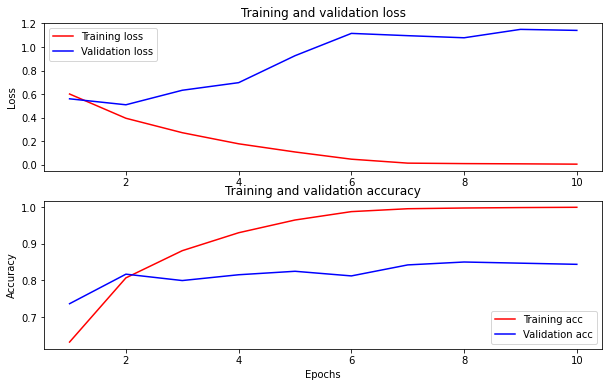

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#**Evaluación**

###**Evaluación de Modelos con Corpus Propio**

In [ ]:
listas_cp=[["Random Forest",accuracy_randomforest_cp],["Naive Bayes",accuracy_nb_cp],["SVC",accuracy_svc_cp],["Logistic Regression",accuracy_logistic_cp],["XGBoost",accuracy_xgb_cp],
           ["Neural Network",accuracy_nn_cp]]
df_listas_cp=pd.DataFrame(listas_cp,columns=["Modelos","Métrica - Accuracy"])
df_listas_cp
df_listas_cp.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

###**Evaluación de Modelos con el Corpus Unido**

In [ ]:
listas=[["Random Forest",accuracy_randomforest],["Naive Bayes",accuracy_nb],["SVC",accuracy_svc],["Logistic Regression",accuracy_logistic],["XGBoost",accuracy_xgb],
         ["Neural Network",accuracy_nn]]
df_listas=pd.DataFrame(listas,columns=["Modelos","Métrica - Accuracy"])
df_listas
df_listas.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#FFFFFF'})

# **Pruebas**

In [ ]:
a="Estoy en vivo en el Show de @juanpisrules \n\nComparte con tus amigas y amigos, también pueden participar con el #PetroskyEnJuanpis \n\n¡Los y las quiero mucho!\n\nSeñal en vivo: https://t.co/gZpFV34NbZ"
print(remove_links(a))

In [ ]:
def detection_fake_news_(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf_cp.transform(input_data)
    prediction = best_model_svc_cp.predict(vectorized_input_data)
    prediction_proba = best_model_svc_cp.predict_proba(vectorized_input_data)
    print (prediction_proba)
     
    if prediction==0:
      print ("La noticia que ingreso es real con una probabilidad de:",prediction_proba[0][0])
    else:
        print ("La noticia que ingreso es falsa con una probabilidad de:",prediction_proba[0][1])

In [ ]:
detection_fake_news_("En medio de uno de los momentos más difíciles para la Coalición Centro Esperanza, y justo cuando la Contraloría declaró reparado el daño patrimonial de $4,3 billones en el caso Hidroituango, el precandidato presidencial Sergio Fajardo habló con EL COLOMBIANO sobre ambos temas.")

# **Modelos para producción**

### Se guardan los modelos para su paso a producción

In [ ]:
#create_model_production("RF",clf)
create_model_production("NB",best_model_nb)
create_model_production("SVC",best_model_svc)
create_model_production("LR",best_model_logistic)
create_model_production("Xgboost",best_model_xgb)
create_model_production("vectorizer",tfidf)
create_model_production("vectorizer_cp",tfidf_cp)